In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import ShapleyIndices
from shapley.tests import ProductGaussian, AdditiveGaussian
from shapley.plots import set_style_paper, plot_sensitivity_results, plot_error, plot_var, plot_cover

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = True

In [2]:
dim = 2
corr = 0.
Model = ProductGaussian

beta = None
model = Model(dim=dim, beta=beta)
theta = [corr]
model.copula_parameters = theta
    
true_results = {
    'Shapley': model.shapley_indices,
    'First Sobol': model.first_sobol_indices,
    'Total Sobol': model.total_sobol_indices
}

In [3]:
from math import factorial

method = 'exact'
n_var = 10000
n_perms = None

n_boot = 1000
n_run = 100

all_n_axes = [3, 9, 18]
n_n_axes = len(all_n_axes)

n_n_ticks = 30
min_n_ticks = factorial(dim) * all_n_axes[-1] * 1
max_n_ticks = factorial(dim) * all_n_axes[-1] * 100

all_n_ticks = np.logspace(np.log10(min_n_ticks), np.log10(max_n_ticks), n_n_ticks, base=10, dtype=int)
all_n_ticks = np.unique(all_n_ticks)
n_n_ticks = len(all_n_ticks)

In [4]:
%%time

all_shapley_results = np.zeros((n_n_ticks, n_n_axes, n_run, dim, n_boot))
all_first_results = np.zeros((n_n_ticks, n_n_axes, n_run, dim, n_boot))
all_total_results = np.zeros((n_n_ticks, n_n_axes, n_run, dim, n_boot))

for i_ticks, n_ticks in enumerate(all_n_ticks):
    for i_axes, n_axes in enumerate(all_n_axes):
        n_inner = n_axes
        n_outer = int(n_ticks / (n_inner * factorial(dim)))
        print('N_ticks:', n_ticks, 'N_axes:', n_axes)
        for i_run in range(n_run):            
            shapley = ShapleyIndices(model.input_distribution)
            shapley.build_sample(model=model, n_perms=n_perms, n_var=n_var, n_outer=int(n_outer), n_inner=int(n_inner))
            shapley_results = shapley.compute_indices(n_boot=n_boot)
            
            all_shapley_results[i_ticks, i_axes, i_run] = shapley_results.full_shapley_indices
            all_first_results[i_ticks, i_axes, i_run] = shapley_results.full_first_indices
            all_total_results[i_ticks, i_axes, i_run] = shapley_results.full_total_indices

N_ticks: 36 N_axes: 3
N_ticks: 36 N_axes: 9
N_ticks: 36 N_axes: 18
N_ticks: 42 N_axes: 3
N_ticks: 42 N_axes: 9
N_ticks: 42 N_axes: 18
N_ticks: 49 N_axes: 3
N_ticks: 49 N_axes: 9
N_ticks: 49 N_axes: 18
N_ticks: 57 N_axes: 3
N_ticks: 57 N_axes: 9
N_ticks: 57 N_axes: 18
N_ticks: 67 N_axes: 3
N_ticks: 67 N_axes: 9
N_ticks: 67 N_axes: 18
N_ticks: 79 N_axes: 3
N_ticks: 79 N_axes: 9
N_ticks: 79 N_axes: 18
N_ticks: 93 N_axes: 3
N_ticks: 93 N_axes: 9
N_ticks: 93 N_axes: 18
N_ticks: 109 N_axes: 3
N_ticks: 109 N_axes: 9
N_ticks: 109 N_axes: 18
N_ticks: 128 N_axes: 3
N_ticks: 128 N_axes: 9
N_ticks: 128 N_axes: 18
N_ticks: 150 N_axes: 3
N_ticks: 150 N_axes: 9
N_ticks: 150 N_axes: 18
N_ticks: 176 N_axes: 3
N_ticks: 176 N_axes: 9
N_ticks: 176 N_axes: 18
N_ticks: 206 N_axes: 3
N_ticks: 206 N_axes: 9
N_ticks: 206 N_axes: 18
N_ticks: 242 N_axes: 3
N_ticks: 242 N_axes: 9
N_ticks: 242 N_axes: 18
N_ticks: 283 N_axes: 3
N_ticks: 283 N_axes: 9
N_ticks: 283 N_axes: 18
N_ticks: 332 N_axes: 3
N_ticks: 332 N_axe

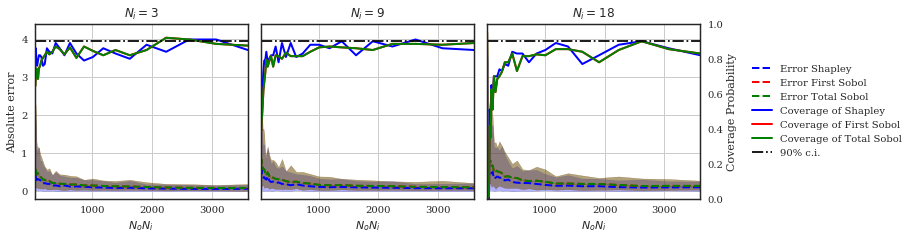

In [5]:
# Coverage probability
ci_prob = 0.10
error_type = 'absolute'
logscale = False
name = 'N_o N_i'
savefigs = True
ci_method = 'bootstrap'

do_cover = False
if n_boot > 1 or method == 'random':
    do_cover = True

if name == 'N_i':
    x_ticks = all_n_inner
    x_axes = all_n_outer
    name_axes = 'N_o'
    axis = 0
elif name == 'N_o':
    x_ticks = all_n_outer
    x_axes = all_n_inner
    name_axes = 'N_i'
    axis = 1
elif name == 'N_o N_i':
    x_ticks = all_n_ticks
    x_axes = all_n_axes
    name_axes = 'N_i'
    axis = 1

n_col = len(x_axes)
fig, axes = plt.subplots(1, n_col, figsize=(2.5*n_col+3, 3.5), sharex=True, sharey=True) 
    
axes = [axes] if n_col == 1 else axes

for i_ax, (N, ax_err) in enumerate(zip(x_axes, axes)):
    
    # Chose the associated result
    results = {
        'Shapley': all_shapley_results.take(i_ax, axis=axis),
        'First Sobol': all_first_results.take(i_ax, axis=axis),
        'Total Sobol': all_total_results.take(i_ax, axis=axis)
    }
            
    plot_error(results, true_results, x_ticks, ax=ax_err, error_type=error_type, logscale=logscale)

    ax_cov = ax_err.twinx()
    ax_cov.set_ylim(0., 1.)
    if do_cover:
        plot_cover(results, true_results, x_ticks, ax=ax_cov, ci_prob=ci_prob, ci_method=ci_method)
        if i_ax < n_col - 1:
            plt.setp(ax_cov.get_yticklabels(), visible=False)
            ax_cov.set_ylabel('')
            ax_cov.set_yticks([])
            
    if i_ax > 0:
        plt.setp(ax_err.get_yticklabels(), visible=False)
        ax_err.set_ylabel('')
        
    ax_err.set_xlabel('$%s$' % (name))
    ax_err.grid()
    ax_err.set_title('$%s = %d$' % (name_axes, N))
    
    if i_ax == n_col-1:
        h_err, l_err = ax_err.get_legend_handles_labels()
        h_cov, l_cov = ax_cov.get_legend_handles_labels()
        ax_err.legend(h_err + h_cov, l_err + l_cov, loc='center left', 
                          bbox_to_anchor=(1.2, 0.5))

fig.tight_layout()
if savefigs:
    figname = './output/%s_precision_dim_%d_%s_nboot_%d' % (Model.__name__, dim, method, n_boot)
    figname += '%s' % (name)
    figname += '_n_ticks_%d_n_naxes_%d_rho_%.2f_Nv_%d_maxNticks_%d_nrun_%d_%s' %\
        (n_n_ticks, n_n_axes, corr, n_var, max_n_ticks, n_run, error_type)
    fig.savefig(figname + '.pdf', bbox_inches='tight')
    fig.savefig(figname + '.png', bbox_inches='tight')